## Variational Inference in Pyro on CIFAR 10

In [124]:
#Paths
dir_path = #INSERT PATH HERE
cifar_path = "cifar-10-batches-py"

#### Google Drive Setup

Ensure that `dir_path` is the correct path to your working directory. It should contain a subdirectory that holds the decompressed files from the CIFAR 10 dataset

In [125]:
#Drive Setup (cuda)

import torch
assert(torch.cuda.is_available())
device = "cuda"

from google.colab import drive
drive.mount('/content/drive')

import os
path_to_batches = dir_path + "/" + cifar_path
batches = [file for file in sorted(os.listdir(path_to_batches)) if "batch" in file]
batches

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'test_batch']

### Data Pre-Processing

#### Unwrapping CIFAR 10 Python Dataset

CIFAR-10 contains 60K 32x32 images divided into 10 clusters. 
- `test_batch` contains 10K samples.
- `data_batch_{1...5}` contains 10K samples each, amounting to total of 50K samples.
- `batches.meta` contains information on the datasets

In [126]:
import pickle
import os
import numpy

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

data_batches = list()
for i, batch in enumerate(batches):
    batch_path = os.path.join(path_to_batches, batch)
    data_batches.append(unpickle(batch_path))

    print(batch)
    print(data_batches[i].keys())

meta_data = data_batches[0]
training_data = data_batches[1:-1]
test_data = data_batches[-1]

batches.meta
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])
data_batch_1
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_2
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_3
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_4
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
data_batch_5
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
test_batch
dict_keys(['batch_label', 'labels', 'data', 'filenames'])


#### CIFAR 10 Databatch Breakdown

The data entry per databatch contains a 10000K samples x 3072 array. The 3072 array corresponds to each 32x32 color image (1024) with a row-major ordering of the 3 channels (R, G, B). The mixture proportions are known, which is why we set θ to constant 1/K = 1/10.

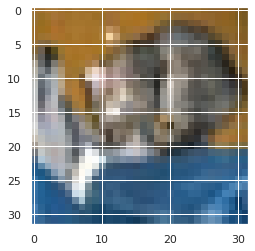

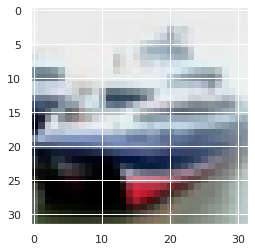

In [127]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

#reshape image to be column order for output
def reshape(input_img):
  return np.transpose(np.reshape(input_img,(3, 32,32)), (1,2,0))

for single_img in test_data['data'][:2]:
  plt.figure()
  plt.imshow(reshape(single_img))

There are 10 labels shown below that correspond to each image. Hence, we use a mixed model to represent the clustering task since only one image can belong to one label. 

In [128]:
num_cases_per_batch = meta_data['num_cases_per_batch']
num_vis = meta_data['num_vis']
label_names = meta_data['label_names']
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

We perform Principle Component Analysis to reduce the dimensions of the image, hence making variational inference much faster.

In [129]:
from sklearn.decomposition import PCA

pca = PCA(100)

image_train = np.ndarray((len(training_data)*num_cases_per_batch, num_vis)) #combine all batches
for i in range(len(training_data)):
  train_batch = training_data[i]['data']
  image_train[i*num_cases_per_batch:(i+1)*num_cases_per_batch] = train_batch

image_train = pca.fit_transform(image_train)
image_test = pca.transform(test_data['data'])

print("train dim: {}, test dim: {}".format(image_train.shape, image_test.shape))

train dim: (50000, 100), test dim: (10000, 100)


#### Building 10-Cluster Mixed Model for Pyro VI

Installing pyro and building mixed model to perform variational inference

In [141]:
!pip install pyro-ppl

import pyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
#import all necessary packages
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.2')
pyro.set_rng_seed(0)

In [143]:
#num_components
k = 10

def model(data):
    """
    Build Multivariate Gaussian Mixture Model

    <HYPERPARMETERS>
    alpha: Dirichlet concentration for mixture proportions
    eta: variance of each mixture component
    k: number of clusters/components
    image_dim: dimension of vector representation (3072)

    <MODEL>
    theta: mixture proportions defined by Dirichlet(alpha)
    beta: mixture components with parameters defined by Multivariate Normal
    z: latent cluster assignment defined by Categorical(theta)
    observations: sample from assigned component
   

    reference: https://docs.pyro.ai/en/dev/infer.autoguide.html#autodelta
    """

    # define the hyperparameters
    alpha = torch.tensor(0.5) 
    eta = pyro.sample("eta", LogNormal(0., 2.))
    n = torch.tensor(len(data)) 
    image_dim = data.shape[1]

    #mixture proportions
    theta = torch.ones(k)/k

    #mixture components (multivariate Gaussians)
    with pyro.plate("components", k):
      #identity for correlation matrix to depict independent components
      beta = pyro.sample("beta", MultivariateNormal(torch.zeros(image_dim), eta*torch.eye(image_dim)))

    #cluster assignments and data
    with pyro.plate("data", n):
      z = pyro.sample("cluster_assignments", Categorical(theta))
      pyro.sample("obs", MultivariateNormal(beta[z], torch.eye(image_dim)), obs=data)


In [144]:
#build auto guide (variational distribution)
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import poutine

auto_guide = AutoDiagonalNormal(poutine.block(model, expose=['beta', 'eta']))
        # ,init_loc_fn=init_loc_fn)

torch.Size([50000, 100])
iteration 0


/usr/local/lib/python3.7/dist-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'cluster_assignments'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


278874146663.1498
iteration 1
278874277625.09375
iteration 2
278874113822.911
iteration 3
278874343122.08496
iteration 4
278874343139.5096
iteration 5
278874146506.0431
iteration 6
278874605269.3901
iteration 7
278873982779.1258
iteration 8
278874244863.182
iteration 9
278874277616.8936
iteration 10
278874343112.73096
iteration 11
278874343186.7996
iteration 12
278874310454.88855
iteration 13
278874769193.0208
iteration 14
278874408792.17395
iteration 15
278874474378.2846
iteration 16
278874802027.78455
iteration 17
278874507206.17804
iteration 18
278874113969.2473
iteration 19
278874638226.0002
iteration 20
278874310623.6264
iteration 21
278874605531.02704
iteration 22
278874212316.22516
iteration 23
278874310626.49036
iteration 24
278874769428.6203
iteration 25
278874081239.4041
iteration 26
278874802172.9031
iteration 27
278874703826.2081
iteration 28
278874081263.18964
iteration 29
278874146803.89716
iteration 30
278874212331.36456
iteration 31
278873524208.5652
iteration 32
278874

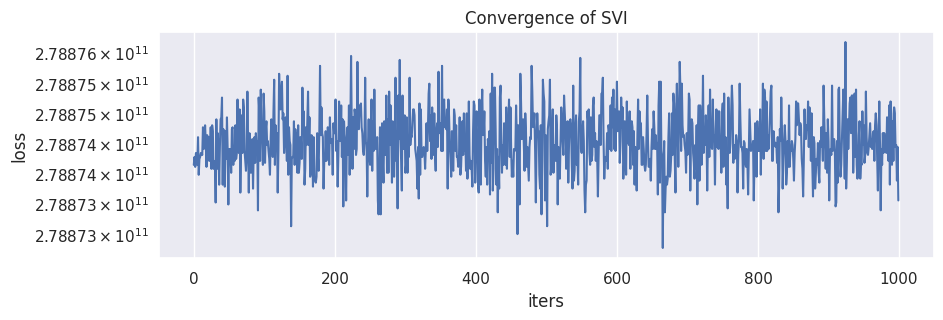

In [145]:
#perform stochastic variational inference
from numpy.random import randint

adam_lr = 0.1
num_iters = 1000

# set up the optimizer
adam_params = {"lr": adam_lr}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, auto_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

#convert full image dataset to tensor
svi_data = torch.from_numpy(image_train)
print(svi_data.shape)
losses = []

# do gradient steps
for step in range(num_iters):
    print("iteration {}".format(step))
    loss = svi.step(svi_data)
    print(loss)
    losses.append(loss)
  
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

### MAP Estimates from Training Dataset

In [146]:
def output_estimates(data, guide):
  map_estimates = guide(data)
  components = map_estimates['beta'].data.numpy()
  variance = map_estimates['eta'].data.numpy()
  print('components {} = {}...\n'.format(components.shape, components[:2,:10]))
  print('variance = {}'.format(variance))
  return components, variance

map_estimate_train = output_estimates(svi_data, auto_guide)

components (10, 100) = [[ 0.02379899 -0.55508804 -0.95430106  0.03081426 -1.9905875  -0.2212776
   0.04022112  1.31582     0.22617221  0.5748071 ]
 [ 0.1304904   1.4573927   0.14901116 -1.0967009  -0.04340988 -0.5418872
  -0.325707   -0.08487976  0.56721157  0.2996624 ]]...

variance = 0.14380614459514618


(10, 100)


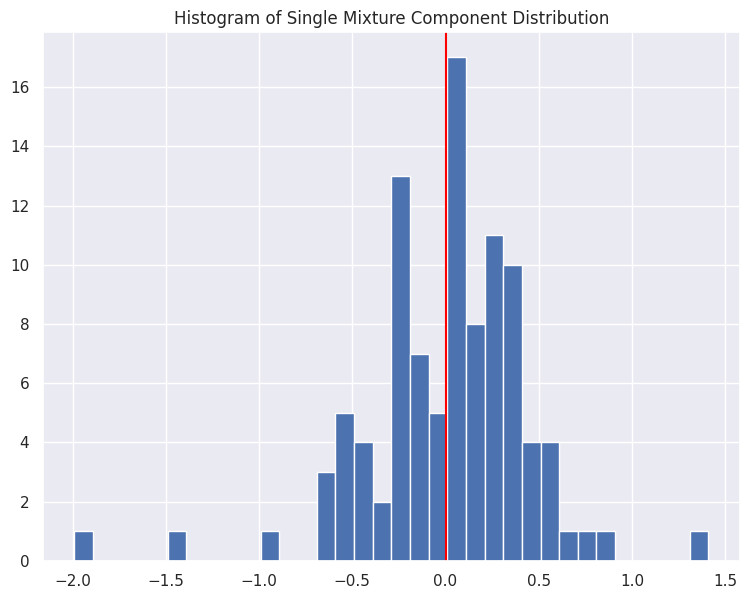

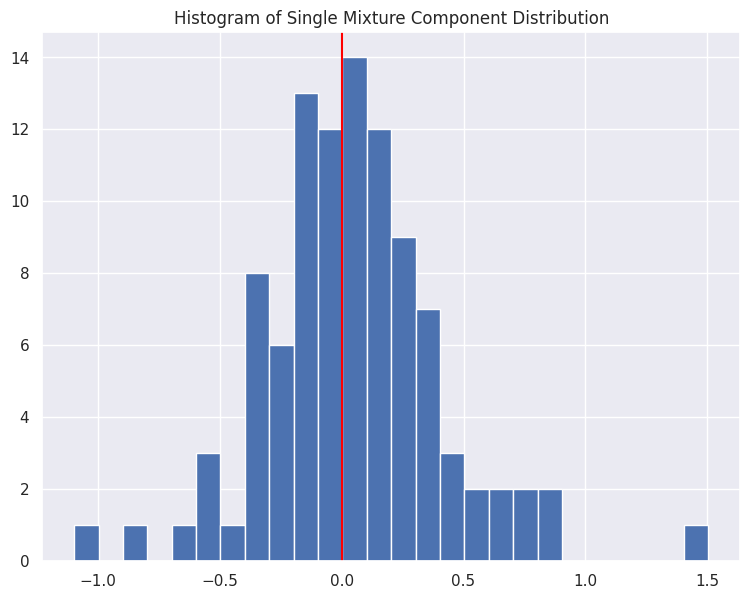

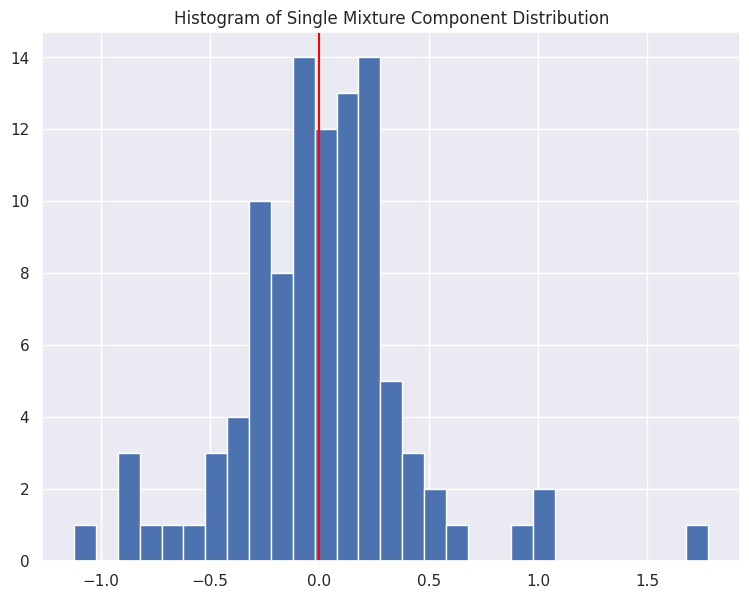

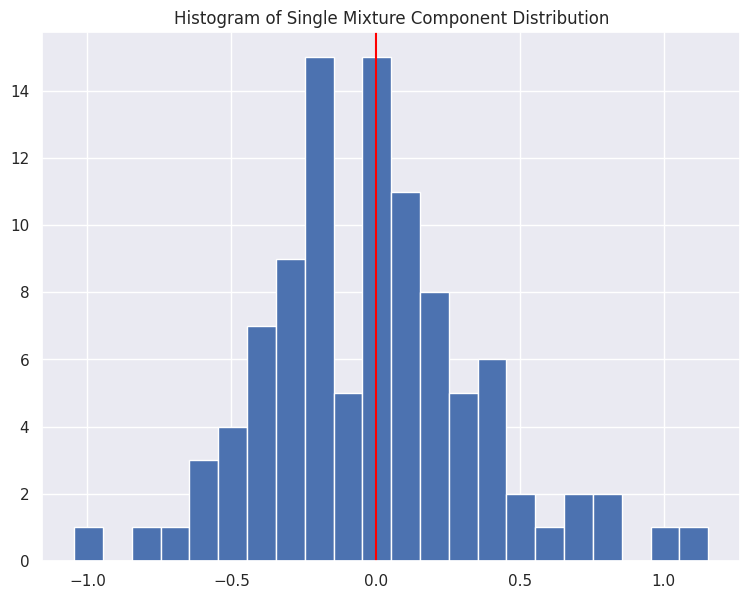

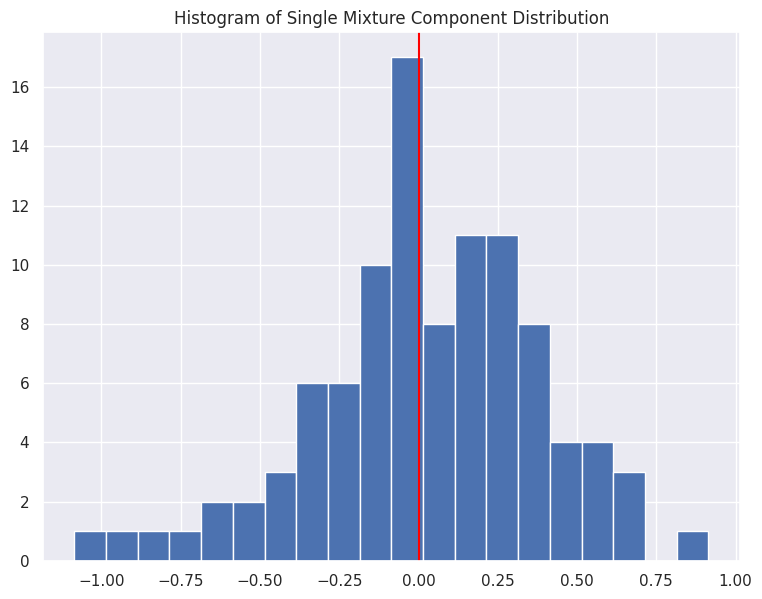

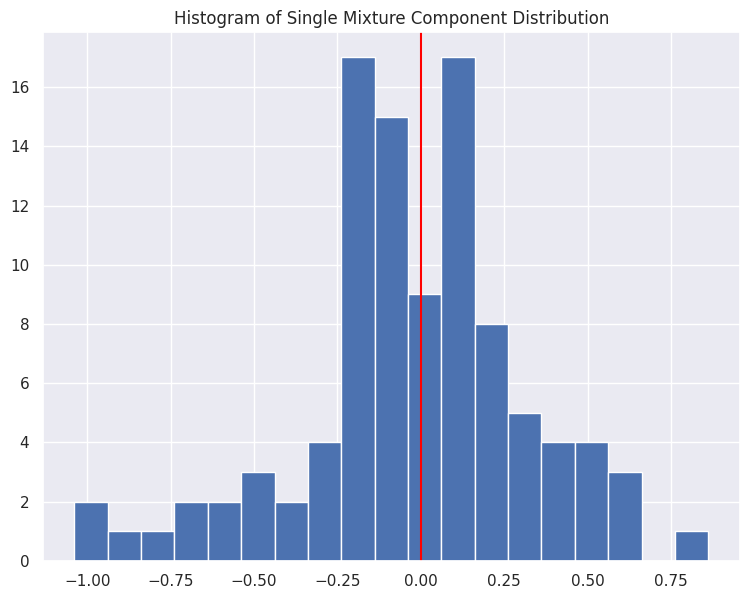

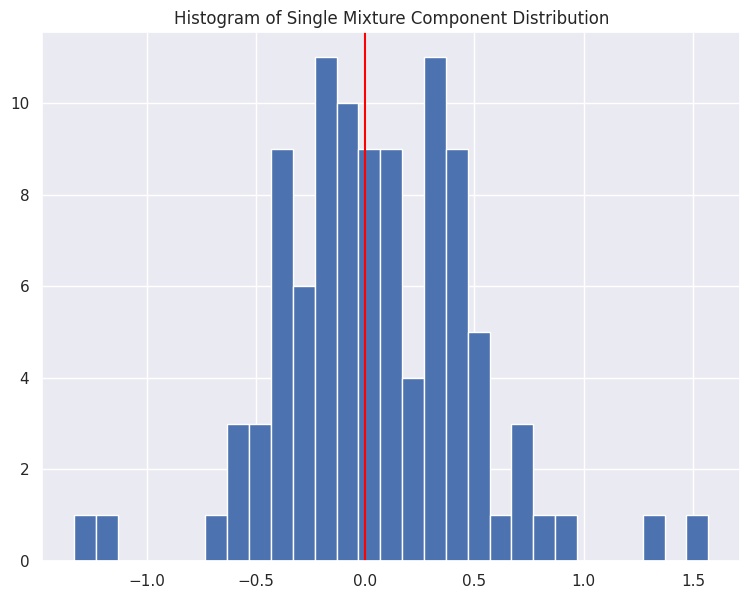

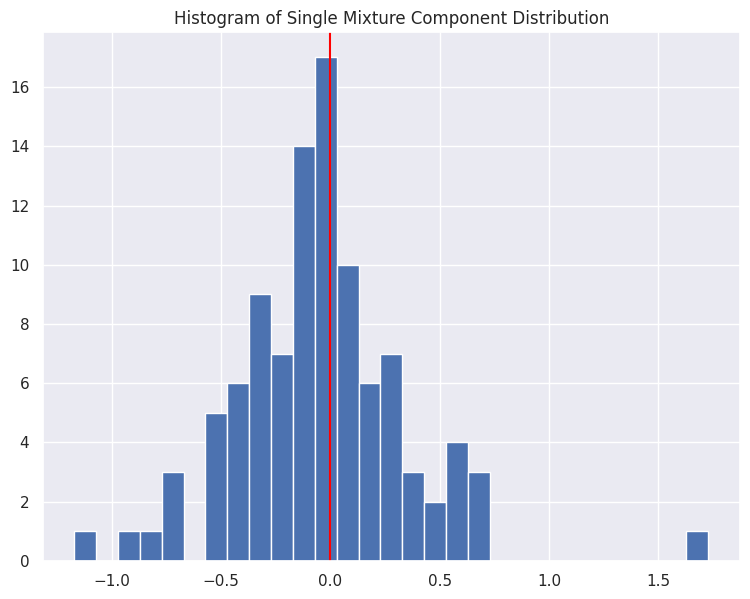

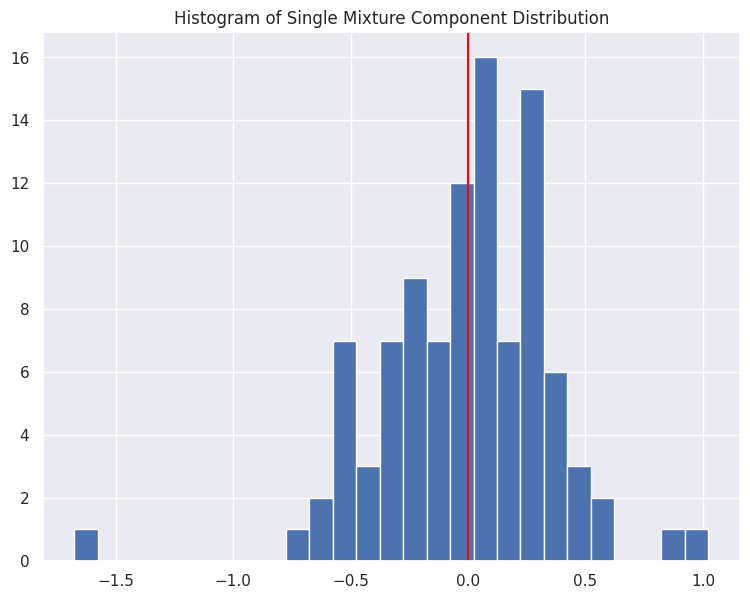

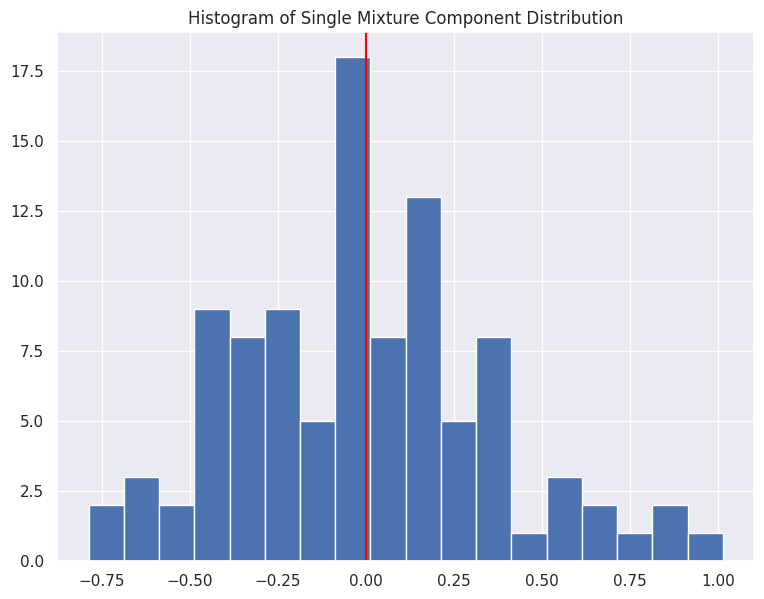

In [147]:
#histogram plots
w = 0.1
print(map_estimate_train[0].shape)
for component in range(map_estimate_train[0].shape[0]):
  hist_component = map_estimate_train[0][component] #select one component to plot component's distribution
  plt.figure(figsize=(9,7), dpi=100).set_facecolor('white')
  plt.hist(hist_component, bins=np.arange(min(hist_component), max(hist_component) + w, w))
  plt.axvline(0, color = "red")
  plt.title('Histogram of Single Mixture Component Distribution')

#### Performing MAP Estimate Training on Held-Out Dataset using Learned Parameters

Using the parameters from the previous SVI on the new held out dataset and observe the ELBO's convergence

In [1]:
held_out_data = torch.from_numpy(image_test)
print(held_out_data.shape)
test_iters = 3000

test_losses = []
for step in range(test_iters):
    print("iteration {}".format(step))
    loss = svi.step(held_out_data)
    print(loss)
    test_losses.append(loss)
  
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(test_losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI (Held-Out Data)');

NameError: ignored

MAP Estimates from Test Dataset

In [ ]:
map_estimate_test = output_estimates(held_out_data, auto_guide)

In [ ]:
#histogram plots
w = 2
hist_component = map_estimate_test[0][2] #select one component to plot component's distribution
plt.figure(figsize=(7,7), dpi=100).set_facecolor('white')
plt.hist(hist_component, bins=np.arange(min(hist_component), max(hist_component) + w, w))
plt.axvline(0, color = "red")
plt.title('Histogram of Mixture Component Distribution (Held-Out Data)');